In [1]:
import ee
import geemap.core as geemap
import geopandas as gpd
import pandas as pd
import fiona

import matplotlib.pyplot as plt
import seaborn as sns

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from scipy.signal import savgol_filter

### Settings

In [2]:
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default
ee.Authenticate()

True

In [3]:
ee.Initialize()

## Process

1. Define a two regions of interest (forest / agricultural field) and timeframe
2. Define a dataset of interest
3. Generate an ee ImageCollection for the area and timeframe
4. Use band math to create VIs
5. Composite and Smooth Data
6. Plot timeseries
8. Create features from curves
9. Show the difference in time series in feature space

## Problem Statement

Let's explore the differneces in NDVI and EVI for two different forests in the United States - a xeric, conifer dominated forest in the mountains of the Pacific Northwest vs. a mesic broadleaf community in north central Wisconsin just south of the boreal forests

#### ROI - Region of Interest

In [4]:
## Import US State Boundaries
us_states = gpd.read_file('/Users/ryangeygan/Downloads/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')

xmin, ymin, xmax, ymax = -129.37, 24.53, -65.30, 48.67

conus = us_states.cx[xmin:xmax, ymin:ymax]

## Import a couple self defined shapefiles for forest patches

pine_forest = gpd.read_file('/Users/ryangeygan/Downloads/mountain_pine_wa.kml')
temperate_broadleaf = gpd.read_file('/Users/ryangeygan/Downloads/broadleaf_wi.kml')

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_37412/3328174610.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wa_centriod = pine_forest.to_crs(epsg='4326').centroid
/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_37412/3328174610.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wi_centriod = temperate_broadleaf.to_crs(epsg='4326').centroid


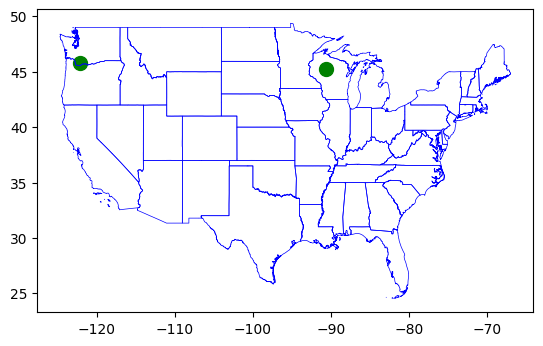

In [5]:
# Plot GeoDataFrame 1 with the boundaries
ax = conus.to_crs(epsg='4326').boundary.plot(color='blue', linewidth=0.5)

# Plot GeoDataFrame 2 centroids
wa_centriod = pine_forest.to_crs(epsg='4326').centroid
wa_centriod.plot(ax=ax, color='green', markersize=100)

# Plot GeoDataFrame 3 centroids
wi_centriod = temperate_broadleaf.to_crs(epsg='4326').centroid
wi_centriod.plot(ax=ax, color='green', markersize=100)

# Show the plot
plt.show()

### Get Harmonized Landsat Sentinel

Let's get the imagery for 6 seasons from spring 2018 to fall 2023

In [12]:
start_date = '2018-01-01'
end_date = '2023-12-31'

geometry_wa = ee.Geometry.Rectangle(list(pine_forest.bounds.iloc[0]))

geometry_wi = ee.Geometry.Rectangle(list(temperate_broadleaf.bounds.iloc[0]))

feature_collection = ee.FeatureCollection([geometry_wi, geometry_wa])

In [13]:
## Get Image Collections for each sensor filter by region and date

col1 = ee.ImageCollection("NASA/HLS/HLSL30/v002").filter( # Harmonized Landsat Collection
    ee.Filter.date(start_date, end_date)).filterBounds( # Filter by Date
    feature_collection).filter( # Filter by region
    ee.Filter.lessThan('CLOUD_COVERAGE', 30)) # Filter out images with over 30% cloud cover

col2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filter( # Harmonized Sentinel Collection
    ee.Filter.date(start_date, end_date)).filterBounds( # Filter by Date
    feature_collection).filter( # Filter by region
    ee.Filter.lessThan('CLOUDY_PIXEL_PERCENTAGE', 30)) # Filter out images with over 30% cloud cover

### Functions to Prepare the Imagery

In [61]:
def create_ndvi_band_OLI(image):
    """
    Takes a Landsat image and returns the Normalized Difference Vegetation Index
    Specific for Landsat Bands
    """

    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    
    return image.addBands(ee.Image(ndvi))

def create_ndvi_band_MSI(image):
    """
    Takes a Landsat image and returns the Normalized Difference Vegetation Index
    Specific for Sentinel Bands
    """

    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    
    return image.addBands(ee.Image(ndvi))

def cloud_mask_OLI(image):
    """
    Updates the mask for an image setting clouds and cloud shadow to zero for Landsat 8/9
    """

    qa = image.select('Fmask')
    
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloud_bit_mask = 1 << 4
    cloud_shadow_bit_mask = 1 << 2
    
    # Both flags should be set to zero, indicating clear conditions.
    mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0))
    )
    
    return image.updateMask(mask)

    return image

def cloud_mask_MSI(image):
    """
    Updates the mask for an image setting clouds and cloud shadow to zero for Sentinel 2
    """

    qa = image.select('QA60')
    
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    
    # Both flags should be set to zero, indicating clear conditions.
    mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )
    
    return image.updateMask(mask)

def get_80p_ndvi(image, geometry):

    return ee.Image(image).reduceRegion(ee.Reducer.percentile([80]), geometry).get('NDVI')

def get_imagery_dates(image):

    return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd')})

def add_z_score(group):
    group['z_score'] = np.abs(stats.zscore(group.ndvi))
    return group


### Apply Functions to Imagery

1. Mask Clouds and Cloud Shadow
2. Create NDVI Band
3. Reduce each region to the 80th percentile NDVI value
4. Create dataframes of 80p NDVI and date

In [78]:
# Apply Cloud Mask and Create NDVI Band for each Collection

landsat_clean_ndvi = col1.map(create_ndvi_band_OLI).map(cloud_mask_OLI)

msi_clean_ndvi = col2.map(create_ndvi_band_MSI).map(cloud_mask_MSI)

# Calculate the 80th percentile value of NDVI for each image in each region and get the time series

landsat_80p_ndvi_timeseries_wa = landsat_clean_ndvi.toList(landsat_clean_ndvi.size()).map(lambda image: get_80p_ndvi(image, geometry_wa)).getInfo()

landsat_80p_ndvi_timeseries_wi = landsat_clean_ndvi.toList(landsat_clean_ndvi.size()).map(lambda image: get_80p_ndvi(image, geometry_wi)).getInfo()

sentinel_80p_ndvi_timeseries_wa = msi_clean_ndvi.toList(msi_clean_ndvi.size()).map(lambda image: get_80p_ndvi(image, geometry_wa)).getInfo()

sentinel_80p_ndvi_timeseries_wi = msi_clean_ndvi.toList(msi_clean_ndvi.size()).map(lambda image: get_80p_ndvi(image, geometry_wi)).getInfo()

# Get Imagery Dates

landsat_dates = landsat_clean_ndvi.map(get_imagery_dates).aggregate_array('date').getInfo()

msi_dates = msi_clean_ndvi.map(get_imagery_dates).aggregate_array('date').getInfo()

# Stitch together the NDVI values and dates

washinton_landsat = pd.DataFrame({'date':landsat_dates, 'ndvi':landsat_80p_ndvi_timeseries_wa, 'sensor':'OLI'}).dropna()
wisconsin_landsat = pd.DataFrame({'date':landsat_dates, 'ndvi':landsat_80p_ndvi_timeseries_wi, 'sensor':'OLI'}).dropna()
washinton_sentinel = pd.DataFrame({'date':msi_dates, 'ndvi':sentinel_80p_ndvi_timeseries_wa, 'sensor':'MSI'}).dropna()
wisconsin_sentinel = pd.DataFrame({'date':msi_dates, 'ndvi':sentinel_80p_ndvi_timeseries_wi, 'sensor':'MSI'}).dropna()

washington_timeseries = pd.concat([washinton_landsat, washinton_sentinel])
wisconsin_timeseries = pd.concat([wisconsin_landsat, wisconsin_sentinel])

### Remove Outliers

In a contiguous, relatively homogenous region with a single land cover type, NDVI values are very commonly normally distributed over time if there is no disturbance or change to the land cover. The forest patches used here are in National Forests and deep in the interior of those forests. Having inspected the time series already, it's clear that there are no significant disturbances to the vegetation. So, we can calculate a z score for all observations and remove those that fall outside two standard deviations from the mean. We'll calculate z scores by sensor even though the data are harmonized

In [79]:
# Apply the function to each group using groupby
shards = [add_z_score(group) for _, group in washington_timeseries.groupby('sensor')]

# Concatenate the resulting DataFrames back together
result_df_wa = pd.concat(shards)

clean_df_wa = result_df_wa[result_df_wa.z_score <= 1.96]

# Apply the function to each group using groupby
shards = [add_z_score(group) for _, group in wisconsin_timeseries.groupby('sensor')]

# Concatenate the resulting DataFrames back together
result_df_wi = pd.concat(shards)

clean_df_wi = result_df_wi[result_df_wi.z_score <= 1.96]

### Monthly Composite by Sensor

To further smooth the data, we now combine all observations across sensors in each month aggregating to the mean.

In [81]:
# First need to cast date columns to datetime values
clean_df_wa['date'] = pd.to_datetime(clean_df_wa['date'])
clean_df_wi['date'] = pd.to_datetime(clean_df_wi['date'])

# Washington

# Extract year and month from 'date' column
clean_df_wa['year'] = clean_df_wa['date'].dt.year
clean_df_wa['month'] = clean_df_wa['date'].dt.month

# Group by 'sensor', year, and month, then compute the mean NDVI value for each group
result_wa = clean_df_wa.groupby(['sensor', 'year', 'month']).agg({'ndvi': 'mean'}).reset_index()

# Combine 'year' and 'month' columns into a single datetime column
result_wa['date'] = pd.to_datetime(result_wa[['year', 'month']].assign(day=1))


# Wisconsin

# Extract year and month from 'date' column
clean_df_wi['year'] = clean_df_wi['date'].dt.year
clean_df_wi['month'] = clean_df_wi['date'].dt.month

# Group by 'sensor', year, and month, then compute the mean NDVI value for each group
result_wi = clean_df_wi.groupby(['sensor', 'year', 'month']).agg({'ndvi': 'mean'}).reset_index()

# Combine 'year' and 'month' columns into a single datetime column
result_wi['date'] = pd.to_datetime(result_wi[['year', 'month']].assign(day=1))

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_37412/190012256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_wa['date'] = pd.to_datetime(clean_df_wa['date'])
/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_37412/190012256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_wi['date'] = pd.to_datetime(clean_df_wi['date'])
/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_37412/190012256.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

## Harmonized Monthly Composites

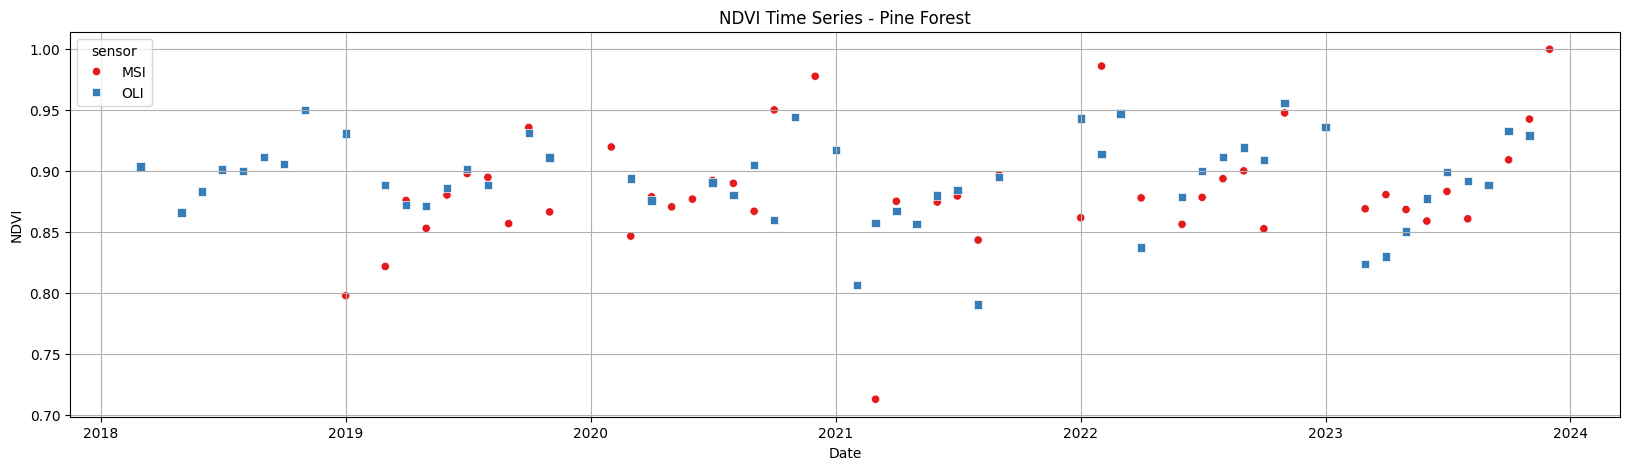

In [82]:
# Set figure size using Matplotlib
plt.rcParams['figure.figsize'] = [20, 5]

# Plot using Seaborn
sns.scatterplot(data=result_wa, x='date', y='ndvi', hue='sensor', palette='Set1', style='sensor', markers=['o', 's'])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series - Pine Forest')

# Display the plot
plt.grid(True)
plt.show()

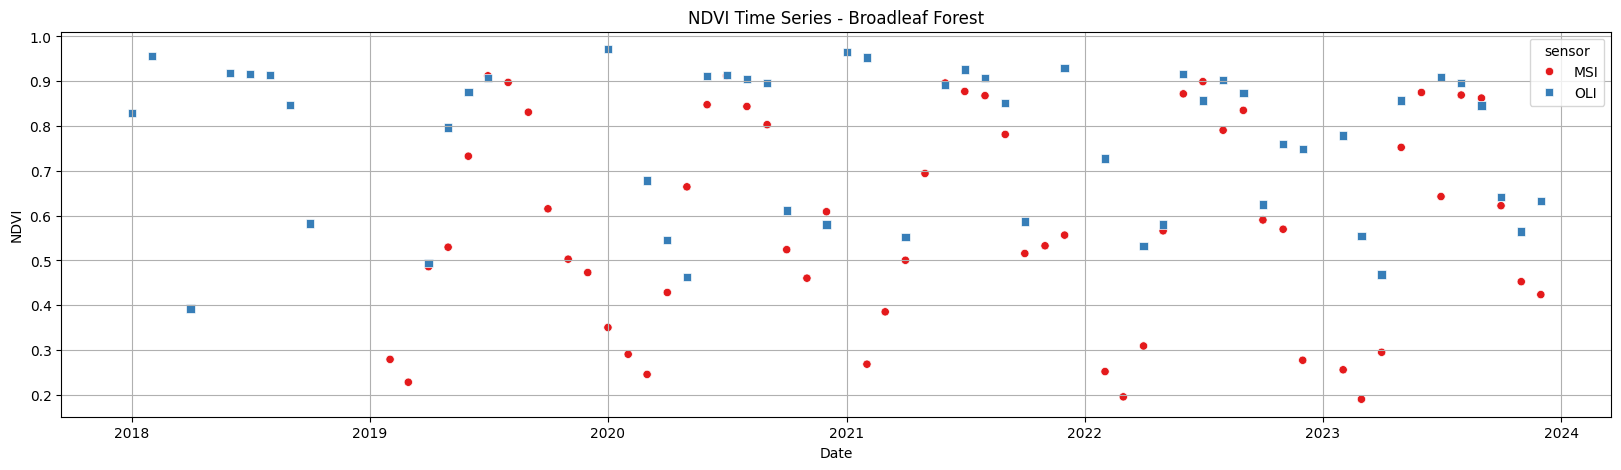

In [83]:
# Set figure size using Matplotlib
plt.rcParams['figure.figsize'] = [20, 5]

# Plot using Seaborn
sns.scatterplot(data=result_wi, x='date', y='ndvi', hue='sensor', palette='Set1', style='sensor', markers=['o', 's'])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series - Broadleaf Forest')

# Display the plot
plt.grid(True)
plt.show()

## Combine Data Across Sensors

In [84]:
# Group by 'date', calculate mean of 'ndvi' and join 'sensor' values if there are multiple sensors
result_wa['sensor'] = result_wa.groupby('date')['sensor'].transform(lambda x: 'combined' if x.nunique() > 1 else x.iloc[0])
df_avg_wa = result_wa.groupby('date').agg({'ndvi': 'mean', 'sensor': 'first'}).reset_index()

# Group by 'date', calculate mean of 'ndvi' and join 'sensor' values if there are multiple sensors
result_wi['sensor'] = result_wi.groupby('date')['sensor'].transform(lambda x: 'combined' if x.nunique() > 1 else x.iloc[0])
df_avg_wi = result_wi.groupby('date').agg({'ndvi': 'mean', 'sensor': 'first'}).reset_index()

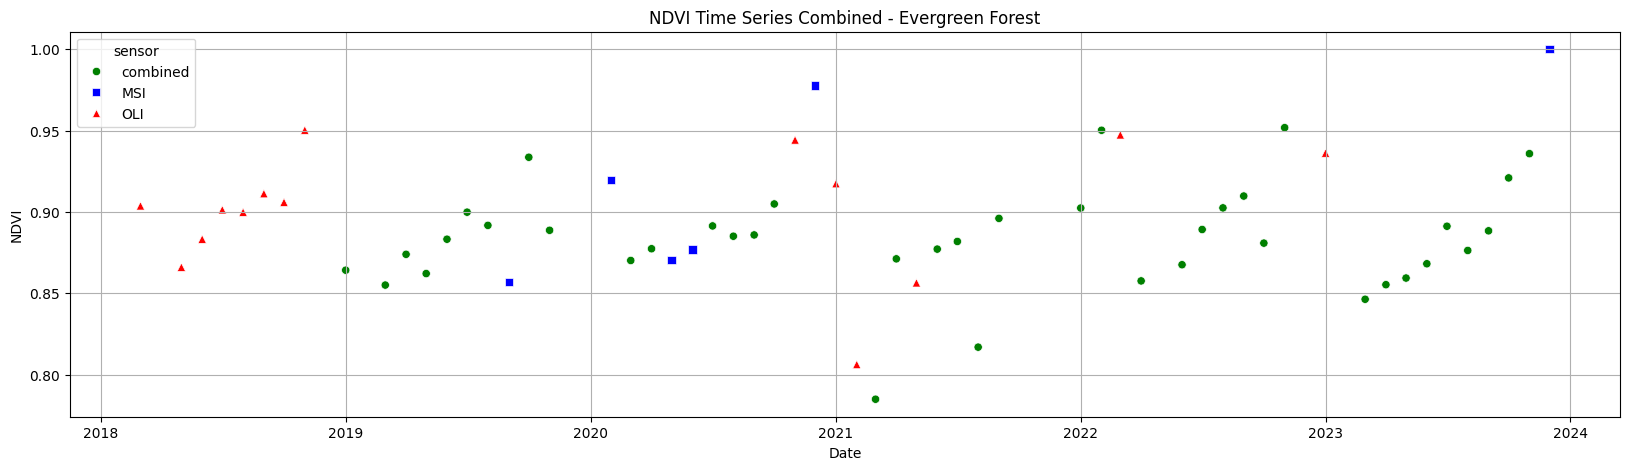

In [94]:
# Define colors for each sensor
color_dict = {'combined': 'green', 'MSI': 'blue', 'OLI': 'red'}

# Specify the order of appearance for the legend
legend_order = ['combined', 'MSI', 'OLI']

# Specify markers for each sensor type
marker_dict = {'combined': 'o', 'MSI': 's', 'OLI': '^'}

# Plot using Seaborn with specific colors, legend order, and markers
sns.scatterplot(data=df_avg_wa, x='date', y='ndvi', hue='sensor', palette=color_dict, hue_order=legend_order, style='sensor', markers=marker_dict)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series Combined - Evergreen Forest')

# Display the plot
plt.grid(True)
plt.show()

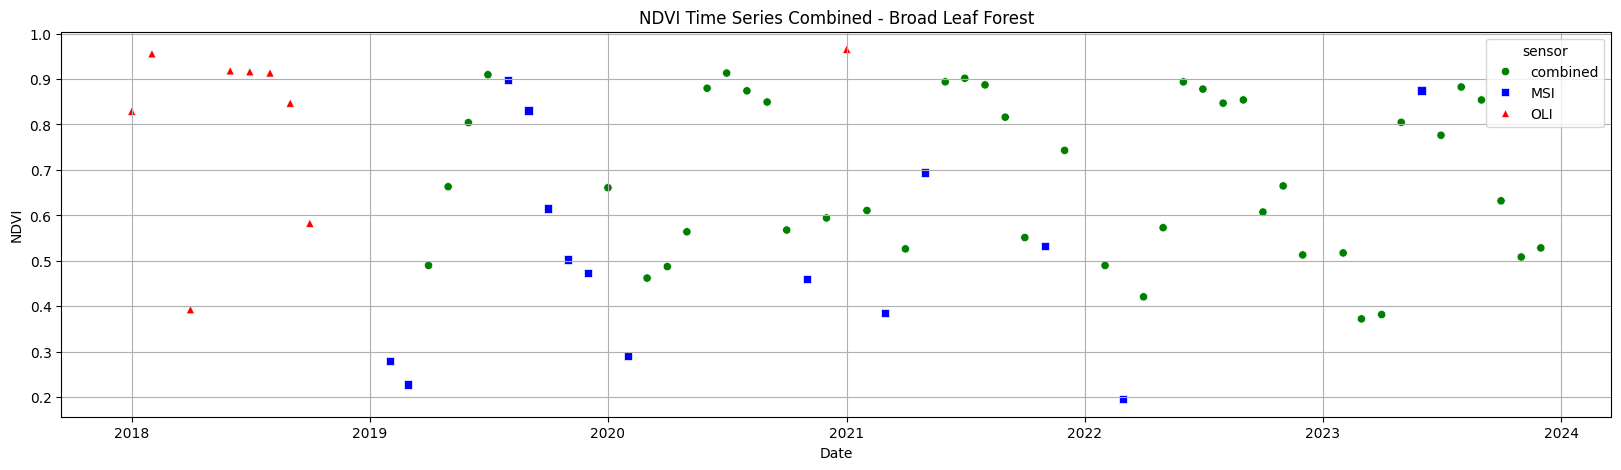

In [95]:
# Define colors for each sensor
color_dict = {'combined': 'green', 'MSI': 'blue', 'OLI': 'red'}

# Specify the order of appearance for the legend
legend_order = ['combined', 'MSI', 'OLI']

# Specify markers for each sensor type
marker_dict = {'combined': 'o', 'MSI': 's', 'OLI': '^'}

# Plot using Seaborn with specific colors, legend order, and markers
sns.scatterplot(data=df_avg_wi, x='date', y='ndvi', hue='sensor', palette=color_dict, hue_order=legend_order, style='sensor', markers=marker_dict)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series Combined - Broad Leaf Forest')

# Display the plot
plt.grid(True)
plt.show()

## Apply Savitsky-Golay Filter to the Datasets

In [96]:
df_avg_wa['smoothed'] = savgol_filter(df_avg_wa.ndvi, 4, 1)

df_avg_wi['smoothed'] = savgol_filter(df_avg_wi.ndvi, 4, 1)

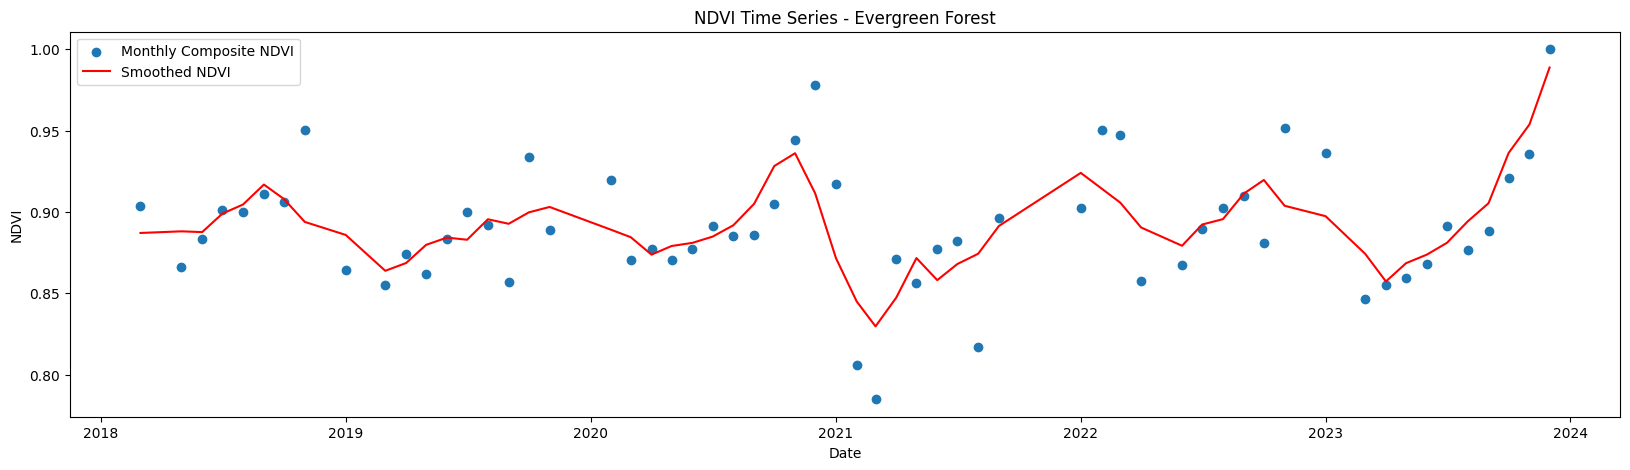

In [97]:
# Plot scatter plot
plt.scatter(x=df_avg_wa['date'], y=df_avg_wa['ndvi'], label='Monthly Composite NDVI')

# Plot smoother
plt.plot(df_avg_wa['date'], df_avg_wa['smoothed'], color='red', label='Smoothed NDVI')

plt.title('NDVI Time Series - Evergreen Forest')

plt.xlabel('Date')
plt.ylabel('NDVI')

# Add legend
plt.legend()

# Show plot
plt.show()

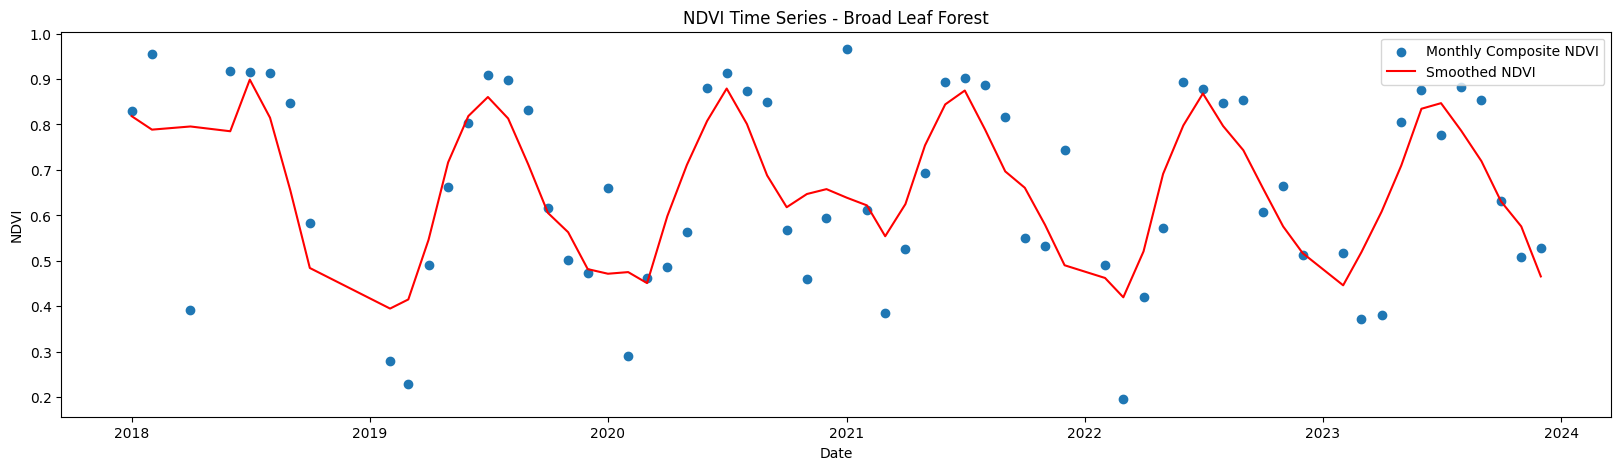

In [98]:
# Plot scatter plot
plt.scatter(x=df_avg_wi['date'], y=df_avg_wi['ndvi'], label='Monthly Composite NDVI')

# Plot smoother
plt.plot(df_avg_wi['date'], df_avg_wi['smoothed'], color='red', label='Smoothed NDVI')

plt.title('NDVI Time Series - Broad Leaf Forest')

plt.xlabel('Date')
plt.ylabel('NDVI')

# Add legend
plt.legend()

# Show plot
plt.show()

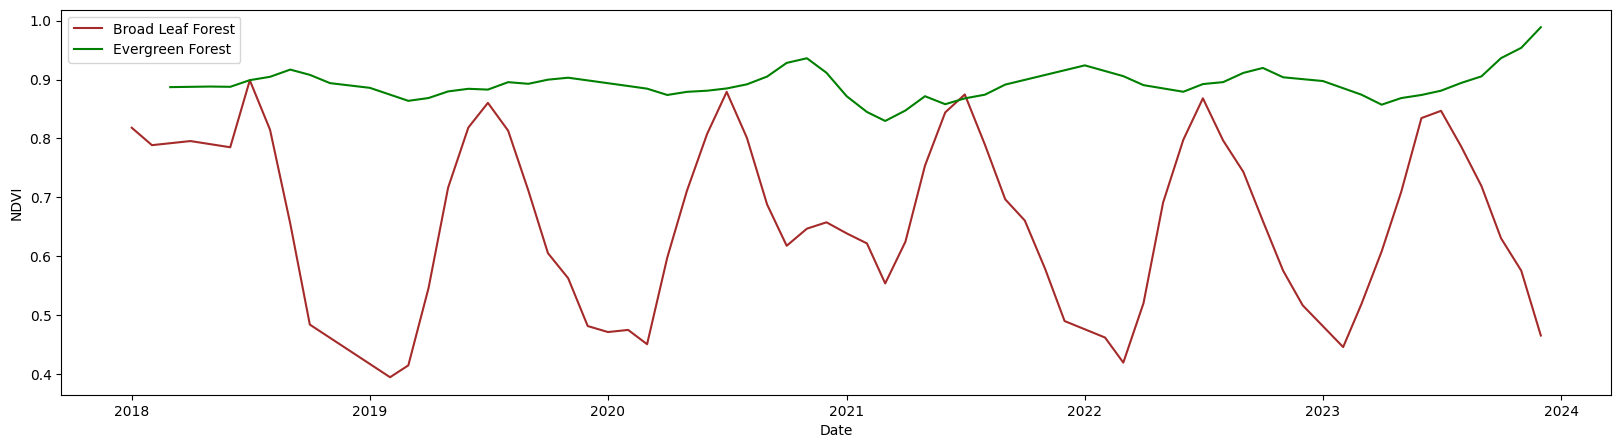

In [99]:
# Plot smoother WI
plt.plot(df_avg_wi['date'], df_avg_wi['smoothed'], color='brown', label='Broad Leaf Forest')

# Plot smoother
plt.plot(df_avg_wa['date'], df_avg_wa['smoothed'], color='green', label='Evergreen Forest')

plt.xlabel('Date')
plt.ylabel('NDVI')

# Add legend
plt.legend()

# Show plot
plt.show()

## Feature Engineering (ToDo)

From the time series data we can create a set of summary features for the different forest types. We would want to create features that capture the overall nature of these curves. Things like peak/trough frequency, peak/trough values, and average yearly value are simple to calculate. Somewhat more difficult but very useful - we could also calculate the timing of the peaks and troughs, the rate of increase/decrease in NDVI, the number of peaks and troughs in a given time span, etc.